# Prototyping LangChain Application with Production Minded Changes

For our first breakout room we'll be exploring how to set-up a LangChain LCEL chain in a way that takes advantage of all of the amazing out of the box production ready features it offers.

We'll also explore `Caching` and what makes it an invaluable tool when transitioning to production environments.


## Task 1: Dependencies and Set-Up

Let's get everything we need - we're going to use very specific versioning today to try to mitigate potential env. issues!

> NOTE: Dependency issues are a large portion of what you're going to be tackling as you integrate new technology into your work - please keep in mind that one of the things you should be passively learning throughout this course is ways to mitigate dependency issues.

In [2]:
%pip install -qU protobuf==3.20.3 langchain_openai==0.2.0 langchain_community==0.3.0 langchain==0.3.0 pymupdf==1.24.10 qdrant-client==1.11.2 langchain_qdrant==0.1.4 langsmith==0.1.121

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 4.1 MB/s eta 0:00:00


We'll need an OpenAI API Key:

In [3]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key:··········


And the LangSmith set-up:

In [4]:
import uuid

os.environ["LANGCHAIN_PROJECT"] = f"AIM Week 8 Assignment 1 - {uuid.uuid4().hex[0:8]}"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

LangChain API Key:··········


Let's verify our project so we can leverage it in LangSmith later.

In [5]:
print(os.environ["LANGCHAIN_PROJECT"])

AIM Week 8 Assignment 1 - f7e43964


## Task 2: Setting up RAG With Production in Mind

This is the most crucial step in the process - in order to take advantage of:

- Asyncronous requests
- Parallel Execution in Chains
- And more...

You must...use LCEL. These benefits are provided out of the box and largely optimized behind the scenes.

### Building our RAG Components: Retriever

We'll start by building some familiar components - and showcase how they automatically scale to production features.

Please upload a PDF file to use in this example!

In [6]:
from google.colab import files
uploaded = files.upload()

Saving Blueprint-for-an-AI-Bill-of-Rights.pdf to Blueprint-for-an-AI-Bill-of-Rights.pdf


In [7]:
file_path = list(uploaded.keys())[0]
file_path

'Blueprint-for-an-AI-Bill-of-Rights.pdf'

We'll define our chunking strategy.

In [8]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

We'll chunk our uploaded PDF file.

In [9]:
from langchain_community.document_loaders import PyMuPDFLoader

Loader = PyMuPDFLoader
loader = Loader(file_path)
documents = loader.load()
docs = text_splitter.split_documents(documents)
for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_{i}"

#### QDrant Vector Database - Cache Backed Embeddings

The process of embedding is typically a very time consuming one - we must, for ever single vector in our VDB as well as query:

1. Send the text to an API endpoint (self-hosted, OpenAI, etc)
2. Wait for processing
3. Receive response

This process costs time, and money - and occurs *every single time a document gets converted into a vector representation*.

Instead, what if we:

1. Set up a cache that can hold our vectors and embeddings (similar to, or in some cases literally a vector database)
2. Send the text to an API endpoint (self-hosted, OpenAI, etc)
3. Check the cache to see if we've already converted this text before.
  - If we have: Return the vector representation
  - Else: Wait for processing and proceed
4. Store the text that was converted alongside its vector representation in a cache of some kind.
5. Return the vector representation

Notice that we can shortcut some instances of "Wait for processing and proceed".

Let's see how this is implemented in the code.

In [10]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain.storage import LocalFileStore
from langchain_qdrant import QdrantVectorStore
from langchain.embeddings import CacheBackedEmbeddings

# Typical Embedding Model
core_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Typical QDrant Client Set-up
collection_name = f"pdf_to_parse_{uuid.uuid4()}"
client = QdrantClient(":memory:")
client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

# Adding cache!
store = LocalFileStore("./cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings, store, namespace=core_embeddings.model
)

# Typical QDrant Vector Store Set-up
vectorstore = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=cached_embedder)
vectorstore.add_documents(docs)
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 3})

##### ❓ Question #1:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

###### Answers

- Local file storage cache might be limiting and slow.
- We could use a GPU backed cache to enable fast response.
- We are using in memory Qdrant database which is not persistent so we could use a highly available qdrant which is persistent with caching.
- Use a persistent storage for caching.

##### 🏗️ Activity #1:

Create a simple experiment that tests the cache-backed embeddings.

In [15]:
### YOUR CODE HERE

os.environ["LANGCHAIN_PROJECT"] = ""

import time
def load_vector_store_time(docs):
  start = time.perf_counter()
  vectorstore.add_documents(docs)
  end = time.perf_counter()
  print(f"Time taken for existing doc: {end - start} seconds")


In [16]:
load_vector_store_time(docs)

Time taken for existing doc: 0.3034061820003444 seconds


In [19]:
# Now uploading a different document that is not in the vectorstore

def load_pdf_spit_doc():
  uploaded = files.upload()
  file_path = list(uploaded.keys())[0]

  Loader = PyMuPDFLoader
  loader = Loader(file_path)
  documents = loader.load()
  docs = text_splitter.split_documents(documents)
  for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_{i}"
  return docs


In [20]:
docs_to_load = load_pdf_spit_doc()
load_vector_store_time(docs_to_load)

Saving NIST.AI.600-1.pdf to NIST.AI.600-1 (1).pdf
Time taken for existing doc: 5.970002872999885 seconds


In [21]:
# Now upload the same docs again to see if cache helps
load_vector_store_time(docs_to_load)

Time taken for existing doc: 0.3691727229997923 seconds


Looking at the result when the same document is uploaded, it took lot less time to load which suggest that it is using the cache.

### Augmentation

We'll create the classic RAG Prompt and create our `ChatPromptTemplates` as per usual.

In [22]:
from langchain_core.prompts import ChatPromptTemplate

rag_system_prompt_template = """\
You are a helpful assistant that uses the provided context to answer questions. Never reference this prompt, or the existance of context.
"""

rag_message_list = [
    {"role" : "system", "content" : rag_system_prompt_template},
]

rag_user_prompt_template = """\
Question:
{question}
Context:
{context}
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", rag_system_prompt_template),
    ("human", rag_user_prompt_template)
])

### Generation

Like usual, we'll set-up a `ChatOpenAI` model - and we'll use the fan favourite `gpt-4o-mini` for today.

However, we'll also implement...a PROMPT CACHE!

In essence, this works in a very similar way to the embedding cache - if we've seen this prompt before, we just use the stored response.

In [23]:
from langchain_core.globals import set_llm_cache
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4o-mini")

Setting up the cache can be done as follows:

In [24]:
from langchain_core.caches import InMemoryCache

set_llm_cache(InMemoryCache())

##### ❓ Question #2:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

- I memory is always limiting in terms of storage and a bottleneck. It doesn't scale as we upload more files and quickly fills the host space.
- Having a CPU backed storage as LLM cache layer would greatly help improving the performance.
- using Cloud hosted solution as cache will improve high availability of the solution.

##### 🏗️ Activity #2:

Create a simple experiment that tests the cache-backed embeddings.

In [28]:
### YOUR CODE HERE

def llm_predict_cache(question):
  start = time.perf_counter()
  chat_model.invoke(question)
  end = time.perf_counter()
  print(f"Time taken for existing doc: {end - start} seconds")

In [30]:
for i in range(1,10):
  llm_predict_cache("Define AI Safety")

Time taken for existing doc: 0.003435294999690086 seconds
Time taken for existing doc: 0.0052994170000602026 seconds
Time taken for existing doc: 0.0019343689996276225 seconds
Time taken for existing doc: 0.0017536550003569573 seconds
Time taken for existing doc: 0.0016854229997989023 seconds
Time taken for existing doc: 0.001712260000203969 seconds
Time taken for existing doc: 0.0016375509999306814 seconds
Time taken for existing doc: 0.0016439899995930318 seconds
Time taken for existing doc: 0.0015720349997536687 seconds


In [31]:
llm_predict_cache("Explain transformer architecture")

Time taken for existing doc: 9.054256625000107 seconds


In [32]:
llm_predict_cache("Explain transformer architecture")

Time taken for existing doc: 0.004715019999821379 seconds


In [33]:
llm_predict_cache("Explain transformer architecture in ML")

Time taken for existing doc: 9.608216627000274 seconds


Note that the very first time a new question is asked it takes long time and then the same questions is raised subsequently it is very quick. Even a small addition to the question in validates the cache.

## Task 3: RAG LCEL Chain

We'll also set-up our typical RAG chain using LCEL.

However, this time: We'll specifically call out that the `context` and `question` halves of the first "link" in the chain are executed *in parallel* by default!

Thanks, LCEL!

In [34]:
from operator import itemgetter
from langchain_core.runnables.passthrough import RunnablePassthrough

retrieval_augmented_qa_chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | chat_prompt | chat_model
    )

Let's test it out!

In [35]:
retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})

AIMessage(content='1. The document is titled "Blueprint for an AI Bill of Rights."\n2. It consists of 73 pages in total.\n3. The document is in PDF format (version 1.6).\n4. It was created using Adobe Illustrator 26.3 on a Macintosh.\n5. The document\'s creation date is September 20, 2022.\n6. The last modification date is October 3, 2022.\n7. There is no author explicitly listed in the document.\n8. The document features a table of contents that outlines its structure.\n9. The table of contents includes sections on "Safe and Effective Systems."\n10. It addresses "Algorithmic Discrimination Protections."\n11. Data privacy is a key topic within the document.\n12. The document discusses "Notice and Explanation" related to AI systems.\n13. It emphasizes "Human Alternatives, Consideration, and Fallback" options.\n14. An appendix is included for additional information.\n15. The document provides examples of automated systems.\n16. It emphasizes the importance of "Listening to the American P

##### 🏗️ Activity #3:

Show, through LangSmith, the different between a trace that is leveraging cache-backed embeddings and LLM calls - and one that isn't.

Post screenshots in the notebook!

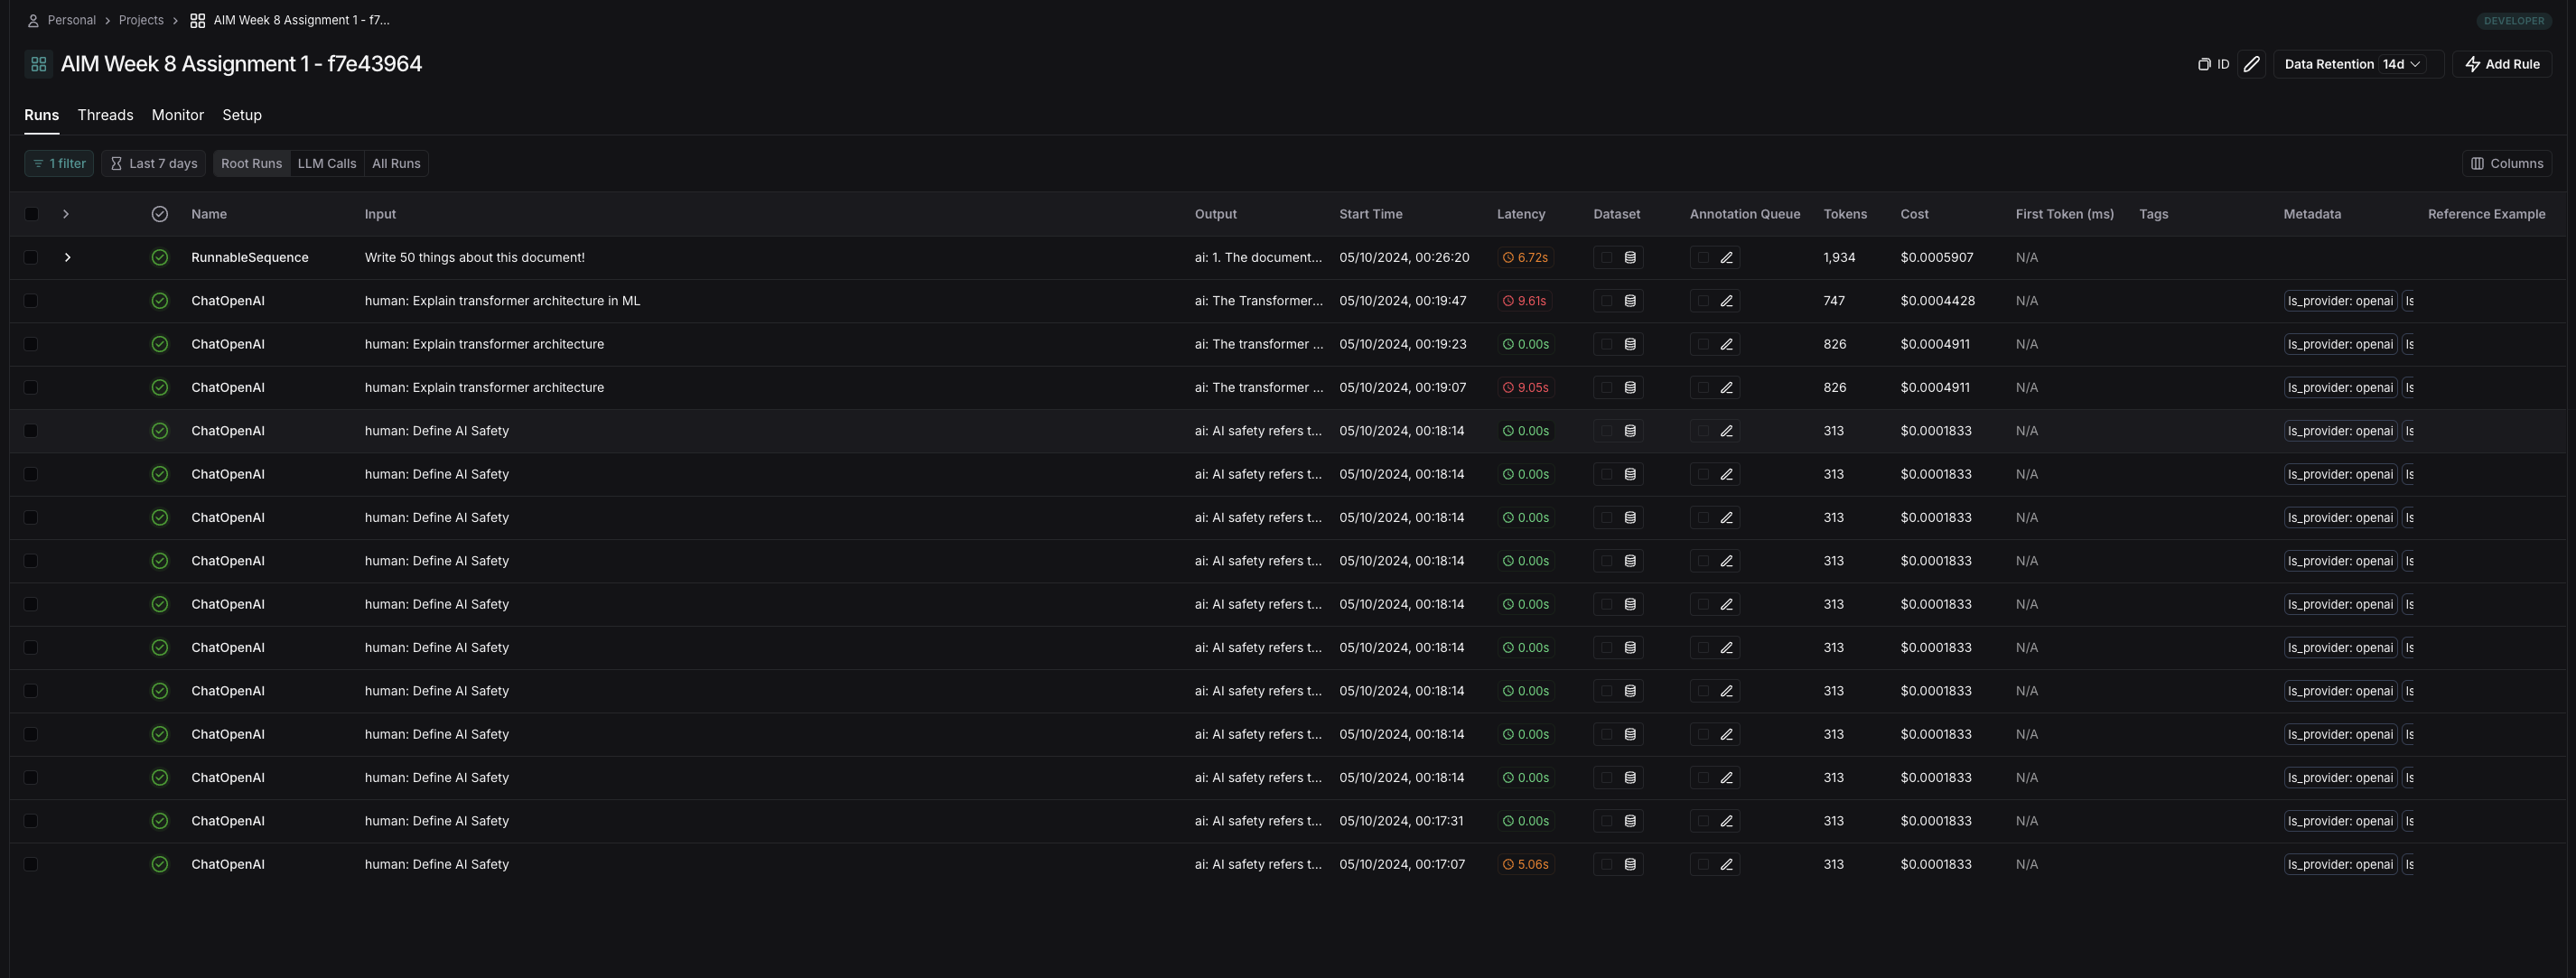
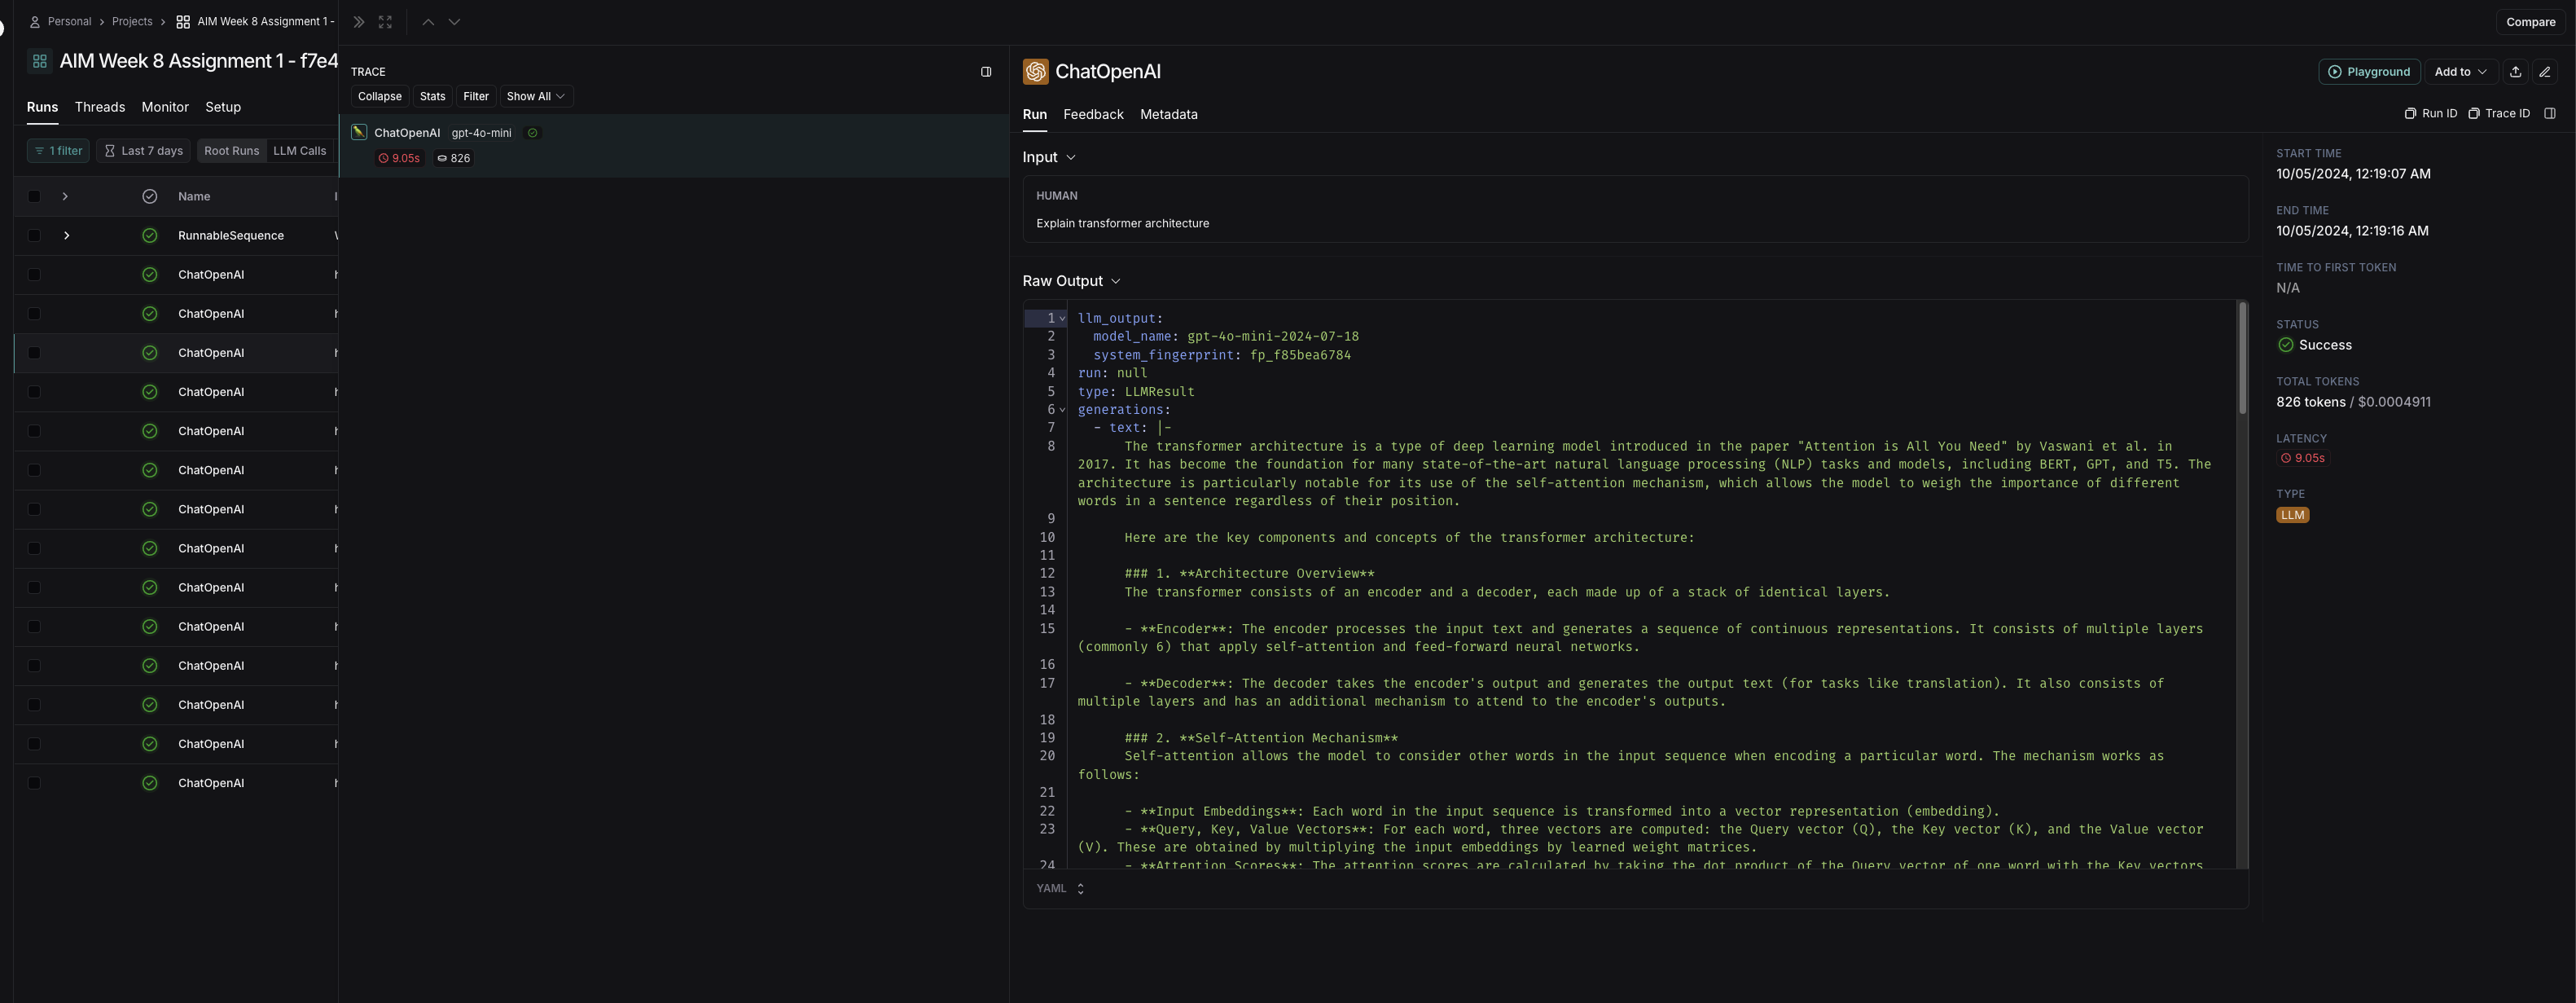
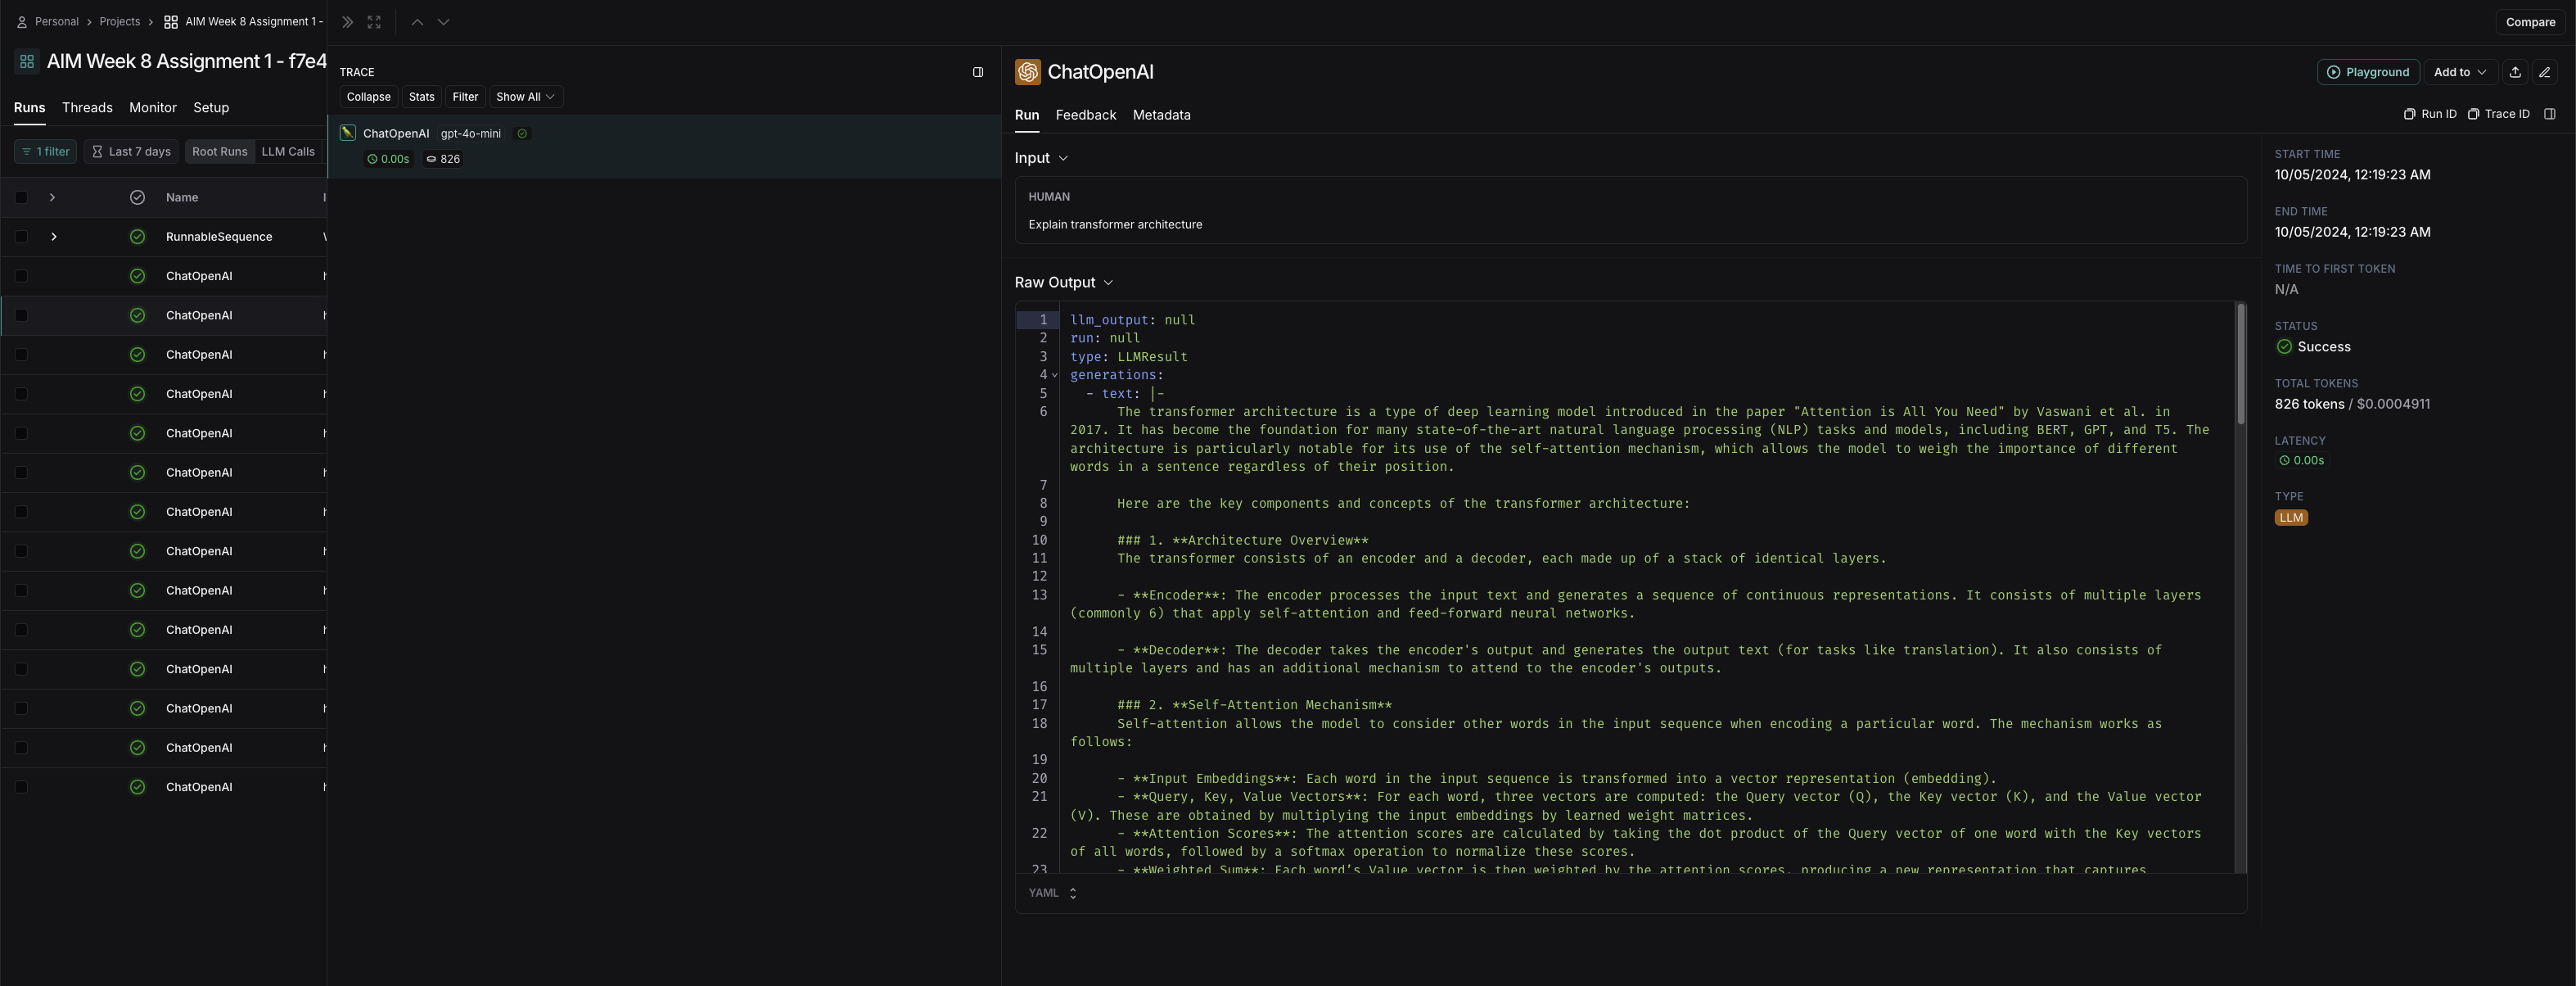